# [E6-7] 작사가 인공지능 만들기

# 루브릭 기준
1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?
 * 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?

 = 그런거 같다...


2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?
 * 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?

 = 진행됐다!! 토큰 길이 조절하는 부분이 어디에 어떤 함수를 사용해야하는지 몰라서 어려웠지만 해결했다. 


3. 텍스트 생성모델이 안정적으로 학습되었는가?
 * 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?

 = loss는 1.08 정확도는 0.80 이다. 그래프를 보면 점점 loss는 줄고 정확도는 늘어나는걸 알 수 있다. 

## 진행 순서
1. 데이터 다운로드
2. 데이터 읽어오기
3. 데이터 정제
4. 데이터셋 내 길이 분포
5. 데이터 토큰화
6. 데이터 분리
7. 데이터 셋 만들기
8. 모델 구현
9. 모델 평가
10. 회고

## Step 1. 데이터 다운로드

* 명령어로 데이터 다운로드 완료!

$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip
$ unzip song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics  #lyrics 폴더에 압축풀기

## Step 2. 데이터 읽어오기

In [2]:
import re                  # 정규표현식을 위한 Regex 지원 모듈 (문장 데이터를 정돈하기 위해) 
import numpy as np         # 변환된 문장 데이터(행렬)을 편하게 처리하기 위해
import tensorflow as tf    # 대망의 텐서플로우!
import os

In [3]:
import glob #파일 읽기
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() # 텍스트를 라인 단위로 끊어서 리스트 형태로 읽어오기  
        raw_corpus.extend(raw) # 흩어진 덱스트를 변수에 집어 넣기

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


## Step 3. 데이터 정제

In [129]:
#raw corpus 데이터에 길이가 없는것 제거, : 있는거 제거
for idx, sentence in enumerate(raw_corpus): 
    if len(sentence) == 0: continue   
    if sentence[-1] == ":": continue  

    if idx > 9: break   
        
    print(sentence)

[Spoken Intro:]
You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 


In [5]:
# 정규표현식
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)      # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)            # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

print(preprocess_sentence("The more you know you shouldn't have it"))   # 이 문장이 어떻게 필터링되는지 확인해 보세요.

<start> the more you know you shouldn t have it <end>


In [6]:
# 정제 데이터 구축하기 정제하고 비어있는 문장이 있는지 확인하기 - 전처리하고 한번더 결측치 확인해야한다.
corpus = []
for sentence in raw_corpus:
    if len(sentence) ==0: continue #빈공간 없애기
    if sentence[-1] == ":": continue    
    corpus.append(preprocess_sentence(sentence))
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>']

# step 4. 데이터셋 내 길이 분포
## * 데이터 내 길이 확인하기


#### 첫번째 문제 : 토큰화 길이 조절
* 여기서 너무 헤멨다. 노드에는 토큰 15이상은 없애라고 했는데 어떤걸 사용해야할지 헷갈렸다.
* 처음엔 counter을 사용해서 문장 길이를 찾으려고 했지만 토큰 길이랑 상관없는거 같아서 다른 방법을 찾았다.
* 문장 길이 조절을 토큰화 전에 적용해야 하는지 후에 적용해야 하는지 모르겠어서 토큰화를 더 자세히 공부하게 됐다. 

__ 해결책: 프로젝트 4번을 참고! 데이터를 정제한 후 문장의 길이 확인-적절한 문장 길이 지정- 토큰화

In [14]:
print(corpus[2])
print("문자길이",len(corpus[0]))
print("문자길이",len(corpus[1]))

<start> that you know you shouldn t have <end>
문자길이 26
문자길이 37


In [15]:
num_tokens = [len(tokens) for tokens in corpus]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  51.26072979078117
문장길이 최대 :  1478
문장길이 표준편차 :  20.555449915415117


최대 길이 : 1478
평균 길이 : 51.26072979078117


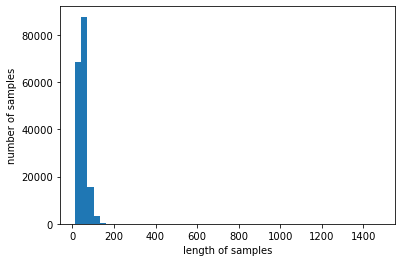

In [19]:
import matplotlib.pyplot as plt
print('최대 길이 :', np.max(num_tokens))
print('평균 길이 :', np.mean(num_tokens))
plt.hist([len(s) for s in corpus], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## * 적절한 최대 문장 길이 지정

In [133]:
max_len = 15 #여기서 토큰길이를 조절한다!

print('pad_sequences maxlen : ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  15
전체 문장의 0.9642330824072968%가 maxlen 설정값 이내에 포함됩니다. 


In [73]:
corpus_len = []
for sentence in corpus:
    if len(sentence) >40: continue #빈공간 없애기
        
    corpus.append(preprocess_sentence(sentence))
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>']

# step 5. 데이터 토큰화 하기 
* 토큰화하기
* 단어사전 만들기 
* 정수인코딩(sequence 변환)
* 패딩하기

In [134]:

def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',    
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # corpus로부터 Tokenizer가 사전을 자동으로 만듬.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # corpus를 Tensor(숫자)로 바꾼다

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           maxlen=max_len,
                                                           padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer #뒤에 제터레이터를 해줘야해서 tokenizer 추가 

tensor, tokenizer = tokenize(corpus) 

[[   2 1704 1319 ...    0    0    0]
 [   2    8  171 ...    0    0    0]
 [   2   20    8 ...    0    0    0]
 ...
 [   2    5    5 ...    0    0    0]
 [   2    5    5 ...    0    0    0]
 [   2    5    5 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f3eb5023d50>


In [75]:
print(tensor[:3, :10]) #8번째 행, 13번째 열까지 출력

[[   2 1704 1319    3    0    0    0    0    0    0]
 [   2    8  171   65  230    3    0    0    0    0]
 [   2   20    8   40    8 1994   16   82    3    0]]


In [76]:
#단어 사전이 어떻게 구성됐는지 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : end
5 : start
6 : i
7 : ,
8 : you
9 : the
10 : and


# step 6. 데이터 분리

In [135]:
src_input = tensor[:, :-1] #x값
tgt_input = tensor[:, 1:]  #y값

print(src_input[3])
print(tgt_input[0])
print(len(src_input))
print(len(tgt_input))

[   2    9  103    8   40    8 1994   16   82   13    7    3    0    0]
[1704 1319    3    0    0    0    0    0    0    0    0    0    0    0]
940816
940816


In [117]:
# 데이터 분리 
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input, test_size = 0.2)

print(enc_train)
print(enc_val)
print(dec_train)
print(dec_val)

[[  2  13   1 ...   0   0   0]
 [  2  80  57 ...   0   0   0]
 [  2   5   5 ...   0   0   0]
 ...
 [  2  78   6 ...   0   0   0]
 [  2   5   5 ...   0   0   0]
 [  2  76 534 ...   0   0   0]]
[[ 2  5 55 ...  0  0  0]
 [ 2  3  0 ...  0  0  0]
 [ 2 10 33 ...  0  0  0]
 ...
 [ 2  5 79 ...  0  0  0]
 [ 2  5 53 ...  0  0  0]
 [ 2  6 40 ...  0  0  0]]
[[ 13   1 162 ...   0   0   0]
 [ 80  57  13 ...   0   0   0]
 [  5   5   4 ...   0   0   0]
 ...
 [ 78   6  83 ...   0   0   0]
 [  5   5   4 ...   0   0   0]
 [ 76 534  13 ...   0   0   0]]
[[  5  55 158 ...   0   0   0]
 [  3   0   0 ...   0   0   0]
 [ 10  33 920 ...   0   0   0]
 ...
 [  5  79 719 ...   0   0   0]
 [  5  53  22 ...   0   0   0]
 [  6  40  20 ...   0   0   0]]


In [118]:
print("enc data : ", enc_train.shape)
print("enc labels : ", enc_val.shape)
print("dec data : ", dec_train.shape)
print("dec labels : ", dec_val.shape)

enc data :  (752652, 14)
enc labels :  (188164, 14)
dec data :  (752652, 14)
dec labels :  (188164, 14)


In [119]:
#하이퍼파라미터 

batch_size = 256
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

checkpoint_dir

'/home/aiffel-dj54/aiffel/lyricist/data/lyrics/*'

# step 7. 데이터 셋 만들기

#### 두번째 문제: 데이터 셋 만들기 
* numpy array 데이터셋을 만들어서 모델에 제공하는 형태는 익숙했지만 텐서플로우는 좀 헷갈렸다.
* 어떤 함수를 사용해서 데이터를 분리하고 데이터 셋을 만들어야 하는지 알지만 어떤 순서에 써야하는지 내가 맞게 하고 있는건지 확신이 없어서 더 오래 걸렸다.
* 처음엔 numpy array 방식으로 모델을 만들려고 새롭게 프로젝트를 작성했지만 text generator를 진행할때 데이터셋을 지정하는 부분에서 다시 막혔다.

__ 해결책: 프로젝트 5 참고! tf.data.dataset을 만듬 tf.data.Dataset.from_tensor_slices, map 함수 사용함 

__ 프로젝트 6에서 제시한 tf.data.dataset 만드는 형식이 좀 다르지만 더 이해하기 쉬운 방법 선택 

In [120]:
# data setting
def one_hot_label(src_input, tgt_input):
    label = tf.one_hot(tgt_input, depth=12)
    return src_input, tgt_input
print("✅")

✅


In [121]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 14), (None, 14)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((None, 14), (None, 14)), types: (tf.int32, tf.int32)>
✅


# step 8. 모델 구현

In [123]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256 # 차원 
hidden_size = 1034 # 모델에 얼마나 많은 일꾼을 둘지 결정
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [124]:
#모델을 태워서 input shape결정
#12001개의 단어 중 어느 단어의 확률이 가장 높은지 모델링해야한다. 
#1개의 배치당 256개의 문장 데이터 가져옴

for src_sample, tgt_sample in train_dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-5.78423133e-05,  6.74076582e-05,  2.18122204e-06, ...,
          3.02713452e-05,  1.82290620e-04,  1.04690007e-04],
        [-9.00110099e-05,  2.88701376e-05,  1.86472462e-04, ...,
          1.18490847e-04,  2.37519649e-04, -5.70957163e-05],
        [-1.78647009e-04,  1.11766431e-05,  3.77038989e-04, ...,
         -1.15140465e-04,  2.86991795e-04, -2.80097447e-04],
        ...,
        [-9.19712420e-06,  5.17933979e-04, -3.09934956e-04, ...,
          2.23352708e-05,  3.18776583e-04,  1.28103129e-03],
        [ 3.23068030e-04,  7.71530962e-04, -3.86432454e-04, ...,
          2.45713833e-04,  4.33428097e-04,  1.66961655e-03],
        [ 6.75959862e-04,  1.05538685e-03, -4.39028983e-04, ...,
          4.51820000e-04,  5.63853770e-04,  2.04637088e-03]],

       [[-5.78423133e-05,  6.74076582e-05,  2.18122204e-06, ...,
          3.02713452e-05,  1.82290620e-04,  1.04690007e-04],
        [ 4.92699437e-05,  1.63016637e-04, -4

In [125]:
model.summary()

Model: "text_generator_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_10 (LSTM)               multiple                  5339576   
_________________________________________________________________
lstm_11 (LSTM)               multiple                  8557384   
_________________________________________________________________
dense_5 (Dense)              multiple                  12421035  
Total params: 29,390,251
Trainable params: 29,390,251
Non-trainable params: 0
_________________________________________________________________


# 모델 학습

In [126]:
optimizer=tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])
print("✅")

✅


#### Call back 함수
* model. fit 함수 사용할때, callback 함수 이용해서 중간에 원하는 동작하도록 설정할 수 있다.
* 모델을 재사용하기 위해서 모델 가중치를 저장하는 함수다. 

In [127]:
#val_loss를 모니터하고 loss가 낮아지면 모델 파라미터를 자동 저장
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [128]:
# 모델 학습코드

history= model.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(enc_train) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(enc_val) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
2940/2940 [==============================] - ETA: 0s - loss: 2.1097 - accuracy: 0.6635
Epoch 00001: val_loss improved from inf to 1.85044, saving model to /home/aiffel-dj54/aiffel/lyricist/data/lyrics/*
2940/2940 [==============================] - 519s 176ms/step - loss: 2.1097 - accuracy: 0.6635 - val_loss: 1.8504 - val_accuracy: 0.6868
Epoch 2/10
2940/2940 [==============================] - ETA: 0s - loss: 1.7190 - accuracy: 0.6998
Epoch 00002: val_loss improved from 1.85044 to 1.61856, saving model to /home/aiffel-dj54/aiffel/lyricist/data/lyrics/*
2940/2940 [==============================] - 480s 163ms/step - loss: 1.7190 - accuracy: 0.6998 - val_loss: 1.6186 - val_accuracy: 0.7125
Epoch 3/10
2940/2940 [==============================] - ETA: 0s - loss: 1.5044 - accuracy: 0.7264
Epoch 00003: val_loss improved from 1.61856 to 1.45569, saving model to /home/aiffel-dj54/aiffel/lyricist/data/lyrics/*
2940/2940 [==============================] - 506s 172ms/step - loss: 1.5044 

# step 9. 학습결과 plot

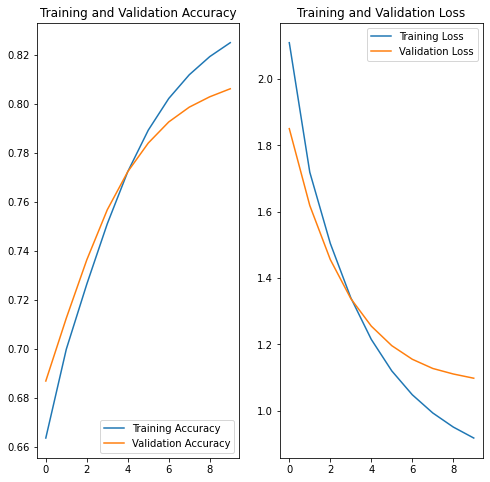

✅


In [130]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

# step 10. 모델 평가

In [131]:
# 이후에 generate text 다시 한다. max_len 원하는 길이로 조절

def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor,tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [132]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he s got a gold watch <end> '

# 회고

1. 초반에 토큰 길이를 정하는 부분에서 토큰화 다음에 해야하는지 앞에 해야하는지 혼란스러웠다.
2. 어떤 함수를 사용해야하는지 알아도 어떤 순서에 해야할지 몰라서 시간낭비를 많이 했다...
3. 크게 2가지 문제가 있었다. 토큰 최대 길이 지정과 데이터셋 만들기 - 여러 노드와 프로젝트를 참고하면서 문제를 해결했다.
이 과정에서 데이터셋과 모델 만드는 두가지 방법을 익힐 수 있었다.
4. 인공지능 모델을 만들어도 노드와 프로젝트마다 방법이 달라서 아직은 머리에 정리가 안되고 혼란스럽지만,
이번 프로젝트 이후에 다시 복습하면서 정리할 필요를 느꼈다.